## Spark Streaming - Twitter

Acesse http://localhost:4040 sempre que quiser acompanhar a execução dos jobs

In [11]:
# Pode ser necessário instalar esses pacotes
#!pip install requests_oauthlib
#!pip install twython
# !pip install nltk

In [12]:
# Módulos usados
from pyspark.streaming import StreamingContext
from pyspark import SparkContext
from requests_oauthlib import OAuth1Session
from operator import add
import requests_oauthlib
from time import gmtime, strftime
import requests
import time
import string
import ast
import json
#import re

In [13]:
# Pacote NLTK
import nltk
from nltk.classify import NaiveBayesClassifier
from nltk.sentiment import SentimentAnalyzer
from nltk.corpus import subjectivity
from nltk.corpus import stopwords
from nltk.sentiment.util import *

In [14]:
# Frequência de update
INTERVALO_BATCH = 5

In [15]:
# Criando o StreamingContext
ssc = StreamingContext(spark, INTERVALO_BATCH)

In [16]:
!pwd

/Users/vladimiralencar/Dropbox/BigDataAnalytics/spark/Curso_Spark_DSA/chap08/5-Projeto2


## Treinando o Classificador de Análise de Sentimento

Uma parte essencial da criação de um algoritmo de análise de sentimento (ou qualquer algoritmo de mineração de dados) é ter um conjunto de dados abrangente ou "Corpus" para o aprendizado, bem como um conjunto de dados de teste para garantir que a precisão do seu algoritmo atende aos padrões que você espera. Isso também permitirá que você ajuste o seu algoritmo a fim de deduzir melhores (ou mais precisas) características de linguagem natural que você poderia extrair do texto e que vão contribuir para a classificação de sentimento, em vez de usar uma abordagem genérica. Tomaremos como base o dataset de treino fornecido pela Universidade de Michigan, para competições do Kaggle (https://inclass.kaggle.com/c/si650winter11).

Esse dataset contém 1,578,627 tweets classificados e cada linha é marcada como: 

### 1 para o sentimento positivo 
### 0 para o sentimento negativo 

In [17]:
# Lendo o arquivo texto e criando um RDD em memória com Spark
arquivo = spark.read.csv("dataset_analise_sentimento.csv", header=True)

In [18]:
type(arquivo)

pyspark.sql.dataframe.DataFrame

In [19]:
arquivo.show(8)

+------+---------+---------------+--------------------+
|ItemID|Sentiment|SentimentSource|       SentimentText|
+------+---------+---------------+--------------------+
|     1|        0|   Sentiment140|                 ...|
|     2|        0|   Sentiment140|                 ...|
|     3|        1|   Sentiment140|              omg...|
|     4|        0|   Sentiment140|          .. Omga...|
|     5|        0|   Sentiment140|         i think ...|
|     6|        0|   Sentiment140|         or i jus...|
|     7|        1|   Sentiment140|       Juuuuuuuuu...|
|     8|        0|   Sentiment140|       Sunny Agai...|
+------+---------+---------------+--------------------+
only showing top 8 rows



In [20]:
# converte de dataframe para RDD
dataset = arquivo.rdd
dataset.take(5)

[Row(ItemID='1', Sentiment='0', SentimentSource='Sentiment140', SentimentText='                     is so sad for my APL friend.............'),
 Row(ItemID='2', Sentiment='0', SentimentSource='Sentiment140', SentimentText='                   I missed the New Moon trailer...'),
 Row(ItemID='3', Sentiment='1', SentimentSource='Sentiment140', SentimentText='              omg its already 7:30 :O'),
 Row(ItemID='4', Sentiment='0', SentimentSource='Sentiment140', SentimentText="          .. Omgaga. Im sooo  im gunna CRy. I've been at this dentist since 11.. I was suposed 2 just get a crown put on (30mins)..."),
 Row(ItemID='5', Sentiment='0', SentimentSource='Sentiment140', SentimentText='         i think mi bf is cheating on me!!!       T_T')]

In [21]:
from pyspark.sql import Row
# Essa função separa as colunas em cada linha, cria uma tupla e remove a pontuação.
def get_row(line):
    #print (line)
    #row = line.split(',')
    sentimento = line['Sentiment']
    tweet = line['SentimentText'].strip()
    translator = str.maketrans({key: None for key in string.punctuation})
#translator = re.compile('[%s]' % re.escape(string.punctuation))
#tweet = regex.sub('', tweet)
    tweet = tweet.translate(translator)
    tweet = tweet.split(' ')
    tweet_lower = []
    for word in tweet:
        tweet_lower.append(word.lower())
    return (tweet_lower, sentimento)

In [22]:
# Aplica a função a cada linha do dataset
dataset_treino = dataset.map(lambda line: get_row(line))

In [23]:
dataset_treino.take(3)

[(['is', 'so', 'sad', 'for', 'my', 'apl', 'friend'], '0'),
 (['i', 'missed', 'the', 'new', 'moon', 'trailer'], '0'),
 (['omg', 'its', 'already', '730', 'o'], '1')]

In [24]:
# Cria um objeto SentimentAnalyzer 
sentiment_analyzer = SentimentAnalyzer()

In [25]:
# Certifique-se de ter espaço em disco - Aproximadamente 5GB
# https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml
# nltk.download()
#nltk.download("stopwords")

In [26]:
#from IPython.display import Image
#Image(url = 'ntlkdata.png')

In [27]:
import nltk

In [28]:
# Obtém a lista de stopwords em Inglês 
stopwords_all = []
for word in stopwords.words('english'):
  stopwords_all.append(word)
  stopwords_all.append(word + '_NEG')

In [29]:
stopwords_all[:8]

['i', 'i_NEG', 'me', 'me_NEG', 'my', 'my_NEG', 'myself', 'myself_NEG']

In [30]:
# Obtém 10.000 tweets do dataset de treino e retorna todas as palavras que não são stopwords
dataset_treino_amostra = dataset_treino.take(10000)

In [31]:
dataset_treino_amostra[:3]

[(['is', 'so', 'sad', 'for', 'my', 'apl', 'friend'], '0'),
 (['i', 'missed', 'the', 'new', 'moon', 'trailer'], '0'),
 (['omg', 'its', 'already', '730', 'o'], '1')]

In [32]:
all_words_neg = sentiment_analyzer.all_words([mark_negation(doc) for doc in dataset_treino_amostra])
all_words_neg_nostops = [x for x in all_words_neg if x not in stopwords_all]

In [33]:
all_words_neg[:10]

['is', 'so', 'sad', 'for', 'my', 'apl', 'friend', 'i', 'missed', 'the']

In [34]:
# Cria um unigram e extrai as features
unigram_feats = sentiment_analyzer.unigram_word_feats(all_words_neg_nostops, top_n = 200)
sentiment_analyzer.add_feat_extractor(extract_unigram_feats, unigrams = unigram_feats)
training_set = sentiment_analyzer.apply_features(dataset_treino_amostra)

In [35]:
type(training_set)

nltk.collections.LazyMap

In [36]:
training_set[:1]

[({'contains()': False, 'contains(im)': False, 'contains(_NEG)': False, 'contains(amp)': False, 'contains(followfriday)': False, 'contains(dont)': False, 'contains(love)': False, 'contains(day)': False, 'contains(like)': False, 'contains(cant)': False, 'contains(good)': False, 'contains(get)': False, 'contains(go)': False, 'contains(today)': False, 'contains(got)': False, 'contains(time)': False, 'contains(going)': False, 'contains(one)': False, 'contains(want)': False, 'contains(back)': False, 'contains(sad)': True, 'contains(miss)': False, 'contains(u)': False, 'contains(really)': False, 'contains(new)': False, 'contains(2)': False, 'contains(work)': False, 'contains(still)': False, 'contains(great)': False, 'contains(last)': False, 'contains(twitter)': False, 'contains(lol)': False, 'contains(night)': False, 'contains(need)': False, 'contains(follow)': False, 'contains(think)': False, 'contains(see)': False, 'contains(get_NEG)': False, 'contains(much)': False, 'contains(didnt)': Fal

In [37]:
len(training_set)

10000

In [38]:
# Treinar o modelo
trainer = NaiveBayesClassifier.train
classifier = sentiment_analyzer.train(trainer, training_set)

Training classifier


In [39]:
# Testa o classificador em algumas sentenças
test_sentence1 = [(['this', 'program', 'is', 'bad'], '')]
test_sentence2 = [(['tough', 'day', 'at', 'work', 'today'], '')]
test_sentence3 = [(['good', 'wonderful', 'amazing', 'awesome'], '')]
test_set = sentiment_analyzer.apply_features(test_sentence1)
test_set2 = sentiment_analyzer.apply_features(test_sentence2)
test_set3 = sentiment_analyzer.apply_features(test_sentence3)
test_set[0]
#test_set2
#test_set3

({'contains()': False,
  'contains(1)': False,
  'contains(2)': False,
  'contains(3)': False,
  'contains(4)': False,
  'contains(_NEG)': False,
  'contains(already)': False,
  'contains(always)': False,
  'contains(amazing)': False,
  'contains(amp)': False,
  'contains(another)': False,
  'contains(away)': False,
  'contains(awesome)': False,
  'contains(baby)': False,
  'contains(back)': False,
  'contains(bad)': True,
  'contains(bed)': False,
  'contains(best)': False,
  'contains(better)': False,
  'contains(bgt)': False,
  'contains(cant)': False,
  'contains(come)': False,
  'contains(cool)': False,
  'contains(could)': False,
  'contains(damn)': False,
  'contains(day)': False,
  'contains(days)': False,
  'contains(didnt)': False,
  'contains(doesnt)': False,
  'contains(done)': False,
  'contains(dont)': False,
  'contains(dontyouhate)': False,
  'contains(even)': False,
  'contains(even_NEG)': False,
  'contains(ever)': False,
  'contains(everyone)': False,
  'contains(fee

In [40]:
# Autenticação do Twitter 
# https://apps.twitter.com/
consumer_key = "Riew8e4LKVoEJ51HbeOm6wsYA"
consumer_secret = "3pPE1z3kTJGQiY93yCqgLUTURJO2wOcoQCcMbyMbCj4Gm9Hc6N"
access_token = "2904474861-kdalTd2NVus3q0PdvAiD3gB2IlF9IFZzao01ol7"
access_token_secret = "2yHMlMAEUZflpw5swYaLA8EjFyPyPJWnJT84VJoAHDKCU"

In [41]:
# Especifica a URL termo de busca
search_term = 'Trump'
sample_url = 'https://stream.twitter.com/1.1/statuses/sample.json'
filter_url = 'https://stream.twitter.com/1.1/statuses/filter.json?track='+search_term

In [42]:
# Criando o objeto de atutenticação para o Twitter
auth = requests_oauthlib.OAuth1(consumer_key, consumer_secret, access_token, access_token_secret)

In [43]:
sc

<SparkContext master=local[*] appName=PySparkShell>

In [44]:
spark

In [45]:
# Criando o StreamingContext
ssc = StreamingContext(sc, INTERVALO_BATCH)

In [46]:
# Configurando o Stream
rdd = ssc.sparkContext.parallelize([0])
stream = ssc.queueStream([], default = rdd)

In [47]:
type(stream)

pyspark.streaming.dstream.DStream

In [48]:
# Total de tweets por update
NUM_TWEETS = 500  

In [49]:
# Essa função conecta ao Twitter e retorna um número específico de Tweets (NUM_TWEETS)
def tfunc(t, rdd):
  return rdd.flatMap(lambda x: stream_twitter_data())

def stream_twitter_data():
  response = requests.get(filter_url, auth = auth, stream = True)
  print(filter_url, response)
  count = 0
  for line in response.iter_lines():
    try:
      if count > NUM_TWEETS:
        break
      post = json.loads(line.decode('utf-8'))
      contents = [post['text']]
      count += 1
      yield str(contents)
    except:
      result = False

In [50]:
stream = stream.transform(tfunc)

In [51]:
coord_stream = stream.map(lambda line: ast.literal_eval(line))

In [52]:
# Essa função classifica os tweets, aplicando as features do modelo criado anteriormente
def classifica_tweet(tweet):
  sentence = [(tweet, '')]
  test_set = sentiment_analyzer.apply_features(sentence)
  print(tweet, classifier.classify(test_set[0][0]))
  return(tweet, classifier.classify(test_set[0][0]))

In [53]:
# Essa função retorna o texto do Twitter
def get_tweet_text(rdd):
  for line in rdd:
    tweet = line.strip()
    translator = str.maketrans({key: None for key in string.punctuation})
    tweet = tweet.translate(translator)
    tweet = tweet.split(' ')
    tweet_lower = []
    for word in tweet:
      tweet_lower.append(word.lower())
    return(classifica_tweet(tweet_lower))

In [54]:
# Cria uma lista vazia para os resultados
resultados = []

In [55]:
# Essa função salva o resultado dos batches de Tweets junto com o timestamp
def output_rdd(rdd):
  global resultados
  pairs = rdd.map(lambda x: (get_tweet_text(x)[1],1))
  counts = pairs.reduceByKey(add)
  output = []
  for count in counts.collect():
    output.append(count)
  result = [time.strftime("%I:%M:%S"), output]
  resultados.append(result)
  print(result)

In [56]:
# A função foreachRDD() aplica uma função a cada RDD to streaming de dados
coord_stream.foreachRDD(lambda t, rdd: output_rdd(rdd))

In [57]:
# Start streaming
ssc.start()
# ssc.awaitTermination()

['08:20:14', []]
['08:20:39', [('1', 105), ('0', 396)]]
['08:21:02', [('0', 397), ('1', 104)]]
['08:21:27', [('0', 403), ('1', 98)]]
['08:21:52', [('0', 382), ('1', 119)]]
['08:22:16', [('1', 102), ('0', 399)]]
['08:22:43', [('0', 382), ('1', 119)]]
['08:23:08', [('0', 409), ('1', 92)]]


In [ ]:
cont = True
while cont:
  if len(resultados) > 5:
    cont = False

['08:13:14', []]
['08:13:45', [('0', 395), ('1', 106)]]


In [58]:
# Finaliza o streaming
ssc.stop()

['08:23:34', [('0', 388), ('1', 113)]]


In [ ]:
# Grava os resultados
#pathsave = './'
#rdd_save = pathsave +'r'+time.strftime("%I%M%S")
#resultados_rdd = sc.parallelize(resultados) 
#resultados_rdd.saveAsTextFile(rdd_save)

In [59]:
import pandas as pd

In [60]:
resultados

[['08:20:14', []],
 ['08:20:39', [('1', 105), ('0', 396)]],
 ['08:21:02', [('0', 397), ('1', 104)]],
 ['08:21:27', [('0', 403), ('1', 98)]],
 ['08:21:52', [('0', 382), ('1', 119)]],
 ['08:22:16', [('1', 102), ('0', 399)]],
 ['08:22:43', [('0', 382), ('1', 119)]],
 ['08:23:08', [('0', 409), ('1', 92)]],
 ['08:23:34', [('0', 388), ('1', 113)]]]

In [61]:
resultados[1][1]

[('1', 105), ('0', 396)]

In [62]:
#dfsaida = pd.DataFrame()
dict_sentimentos = {}
i = 0
result_sentimento = []
for linha in resultados:
    date = linha[0]
    print(date)
    sentimentos = linha[1]
    #print(sentimentos)
    if len(linha[1]) != 0:
        sentimento = [[x[0],x[1]] for x in sentimentos]
        dict_sentimentos[i] = sentimento
        i+= 1

print("dict_sentimentos:")
print(dict_sentimentos)

08:20:14
08:20:39
08:21:02
08:21:27
08:21:52
08:22:16
08:22:43
08:23:08
08:23:34
dict_sentimentos:
{0: [['1', 105], ['0', 396]], 1: [['0', 397], ['1', 104]], 2: [['0', 403], ['1', 98]], 3: [['0', 382], ['1', 119]], 4: [['1', 102], ['0', 399]], 5: [['0', 382], ['1', 119]], 6: [['0', 409], ['1', 92]], 7: [['0', 388], ['1', 113]]}


In [63]:
print(dict_sentimentos)

{0: [['1', 105], ['0', 396]], 1: [['0', 397], ['1', 104]], 2: [['0', 403], ['1', 98]], 3: [['0', 382], ['1', 119]], 4: [['1', 102], ['0', 399]], 5: [['0', 382], ['1', 119]], 6: [['0', 409], ['1', 92]], 7: [['0', 388], ['1', 113]]}


In [64]:
indices = list(dict_sentimentos.keys())
lista_sentimentos = []
# Percorre a lista de índices, acessando a respectiva posição:
for indice in indices:
    print(dict_sentimentos[indice])
    l = dict_sentimentos[indice]
    print (l[0][0],l[0][1],l[1][0],l[1][1])
    if l[0][0] == '0': 
        count_negativo = l[0][1]
        count_positivo = l[1][1]
        
    if l[0][0] == '1': 
        count_positivo = l[0][1]
        count_negativo = l[1][1]   
        
    print (count_negativo, count_positivo)   
    lista_sentimentos.append([count_negativo, count_positivo])
lista_sentimentos

[['1', 105], ['0', 396]]
1 105 0 396
396 105
[['0', 397], ['1', 104]]
0 397 1 104
397 104
[['0', 403], ['1', 98]]
0 403 1 98
403 98
[['0', 382], ['1', 119]]
0 382 1 119
382 119
[['1', 102], ['0', 399]]
1 102 0 399
399 102
[['0', 382], ['1', 119]]
0 382 1 119
382 119
[['0', 409], ['1', 92]]
0 409 1 92
409 92
[['0', 388], ['1', 113]]
0 388 1 113
388 113


[[396, 105],
 [397, 104],
 [403, 98],
 [382, 119],
 [399, 102],
 [382, 119],
 [409, 92],
 [388, 113]]

In [65]:
# Visualiza os resultados
df = pd.DataFrame(lista_sentimentos, columns=["Negative", "Positive"])

df.reset_index()
df.reindex(index=range(len(df)))
df.index.name = "tweets"
df['Tweets'] = range(len(df))

df

,Negative,Positive,Tweets
tweets,,,
0,396,105,0
1,397,104,1
2,403,98,2
3,382,119,3
4,399,102,4
5,382,119,5
6,409,92,6
7,388,113,7


In [66]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
#import seaborn as sea
from ggplot import ggplot, geom_line, aes

Sentiment Analysis - 01-Abril-2018 - Term: Trump


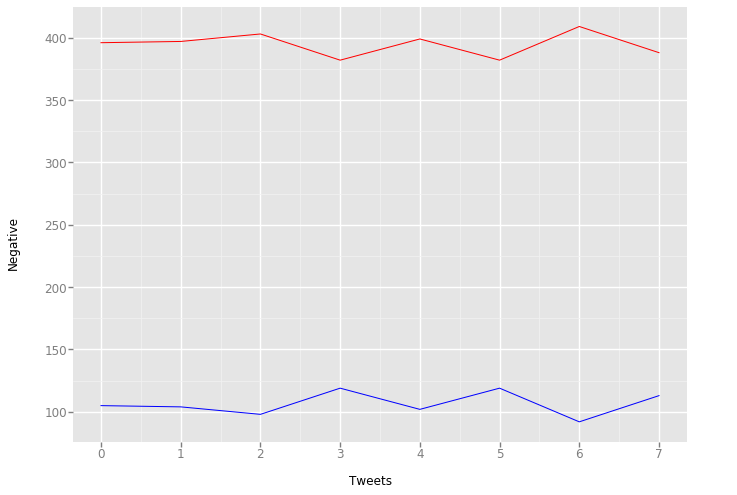

<ggplot: (295589766)>

In [68]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from ggplot import ggplot, geom_line, aes

print ("Sentiment Analysis - 01-Abril-2018 - Term: Trump")
ggplot(aes(x='Tweets'), data=df) +\
    geom_line(aes(y='Positive'), color='blue') +\
    geom_line(aes(y='Negative'), color='red') 

In [75]:
# Grava o dataframe
import datetime
data_hoje = datetime.datetime.today().strftime('%Y-%m-%d')
str = 'sentimentos-'+ search_term + '-' + data_hoje 
print(str)
df.to_csv(str+'.csv')

sentimentos-Trump-2018-04-01


In [ ]:
#resultados_rdd.take(4)

In [ ]:
from pyspark.sql import SQLContext
#sqlContext = SQLContext(sc)

In [ ]:
# Spark Session - usada quando se trabalha com Dataframes no Spark
#spSession = SparkSession.builder.master("local").appName("SparkSQL2").config("spark.some.config.option", "some-value").getOrCreate()

In [ ]:
# Criando um dataframe a partir do RDD
#df = spSession.createDataFrame(resultados_rdd)
#df = sqlContext.createDataFrame(resultados_rdd)

In [ ]:
# Finaliza o streaming
ssc.stop()